In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
plt.style.use(['science', 'notebook', 'grid'])

Import the regression model. This will allow for the prediction of the "perfect" angle at all different times.

In [2]:
regression = load_model('C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 1\\Technique Modelling\\Bicep Curl\\Perfect Technique Modelling\\Models\\Regression.h5')

Import the training data into a list, then concatenate into a numpy array. Also create an array that represents the discritised normalised time where each point corresponds to the data that was imported.

In [3]:
data_list = []
i = 0
while True:
    try:
        file_path = f"C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 1\\Technique Modelling\\Bicep Curl\\Perfect Technique Modelling\\Training Data\\Conc{i}.npy"
        data_inst = np.load(file_path)
        data_list.append(data_inst)
        i+=1
        
    except FileNotFoundError:
            break
            
#Create the time points that will be used to find the "ideal coordinates".
Time = np.linspace(0,1,15)

#Put all the Correct data in an array
Correct = np.concatenate(data_list)

Discover the "perfect" angles at each point in time.

In [4]:
Perfect = regression.predict(Time)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Now define a function that calculates the squared error of each datapoint with respect to the "perfect" technique. Note that since we are working in the coordinate system of angles, we should calculate the squared error in terms of angles, not in terms of the cosine of the angle (gives a different result).

In [5]:
def squared_error(Data, Perfect):
    mse = []
    for i in range(Data.shape[0]):
        mse_instance = (Perfect*np.pi-Data[i]*np.pi)**2 #multiplying by pi changes the "angle" back to radian.
        mse.append(mse_instance)
    mse = np.stack(mse)
    return mse

Now import the unseen data and calculate the squared error for both the unseen and training data.

In [6]:
Unseen = np.load("C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 1\\Technique Modelling\\Bicep Curl\\Perfect Technique Modelling\\Training Data\\incorrectConc3.npy")
correct_se = squared_error(Correct, Perfect)
unseen_se = squared_error(Unseen, Perfect)

Now I need to create a decision boundary, for which to distinguish between "correct" and "incorrect" techniques. This will return at which times the technique is correct or incorrect. This will be in the form of a boolean array:

- True = Correct Technique
- False = Incorrect Technique

The decision boundary is calculated separately for each dimension as follows:
- Identify the maximum squared error in the training data.
- Select a percentage value greater than the maximum value that will define the decision boundary (for example 10% greater).

In [7]:
#note that the unseen_error is only for one instance, so will be of shape (15,3).
#Boundary is a decimal representing the percentage boundary discussed above.
def technique_correctness(boundary, correct_error, unseen_error):
    maximum = np.max(np.max(correct_error, axis=1), axis=0)
    decision_boundary = maximum*(1+boundary)
    return unseen_error<decision_boundary

Now create a function that figures out if the angle is too large or too small in the occasions that the technique is incorrect. This function takes the following parameters:

- correctness = the boolean array returned from the previous function
- unseen = the angle data of the unseen instance of the contraction
- perfect = the angle data for the perfect technique

The function returns an array, where each element is one of the three following values:
- 0 = Correct Technique
- 1 = Angle Too Large
- -1 = Angle Too Small

In [8]:
def technique_feedback(correctness, unseen, perfect):
    #discover the indexes that correspond incorrect technique.
    incorrect_index = np.stack(np.where(correctness==False)).T
    
    #initiate an array that will hold the values representing correct/incorrect technique
    result = np.zeros_like(perfect)
    for index0, index1 in incorrect_index:
        #retrieve the values of unseen and perfect technique
        U = unseen[index0, index1]
        P = perfect[index0, index1]
        if U>P:
            result[index0, index1] = 1
        else:
            result[index0, index1] = -1
    return result

In [9]:
correctness = technique_correctness(0.1,correct_se, unseen_se[0])
result = technique_feedback(correctness, Unseen[0], Perfect)
result

array([[ 0., -1., -1.],
       [ 0., -1., -1.],
       [ 0., -1., -1.],
       [ 0., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1.,  0.],
       [ 1., -1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]], dtype=float32)

Now make a function that returns an array that represents the two decision boundaries either side of the line. Note that this is only for illustrative purposes.

In [10]:
def decision_boundary(boundary, correct_error):
    maximum = np.max(np.max(correct_error, axis=1), axis=0)
    decision_boundary = maximum*(1+boundary)
    #note that decision_boundary is the limit squared error, I can change this to angle data later.
    return decision_boundary

In [11]:
e = decision_boundary(0.05, correct_se)
limit_plus = Perfect*180 + np.sqrt(e)*180/np.pi
limit_minus = Perfect*180 - np.sqrt(e)*180/np.pi

limit_plus, limit_minus

(array([[-79.40975919, -36.13784167, -16.58036192],
        [-80.2357327 , -36.8494086 ,  -7.04226835],
        [-80.34694638, -37.21291873,   2.87157671],
        [-80.0066525 , -37.34718082,  11.91557066],
        [-79.65100064, -37.41806552,  19.60727827],
        [-79.56890073, -37.48365542,  26.32736735],
        [-79.82902493, -37.49250552,  32.84898512],
        [-80.34213223, -37.34137103,  39.89167158],
        [-80.93043485, -36.94034717,  47.81811563],
        [-81.39024319, -36.26883456,  56.45340578],
        [-81.55445828, -35.38926456,  65.13947908],
        [-81.33576169, -34.40695331,  73.06726686],
        [-80.7310864 , -33.41474292,  79.65756075],
        [-79.79666867, -32.46598193,  84.71908418],
        [-78.61692014, -31.57964084,  88.36783449]]),
 array([[ -99.62562595,  -66.71607831,  -65.25221864],
        [-100.45159946,  -67.42764523,  -55.71412508],
        [-100.56281314,  -67.79115537,  -45.80028002],
        [-100.22251926,  -67.92541745,  -36.75628607]

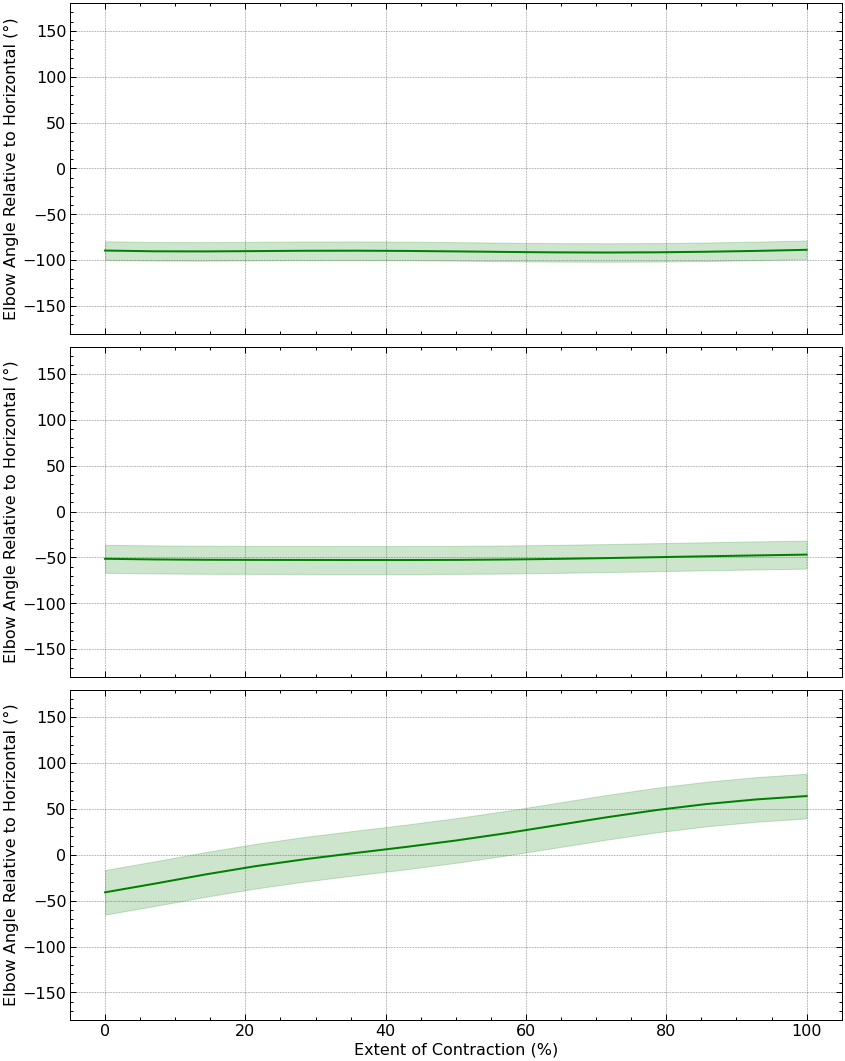

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Set font size for consistency
plt.rcParams.update({'font.size': 12})

# Create figure and axes with appropriate size
fig, ax = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Define colors and labels
colors = ['green', 'red']

# Plot for each feature (assuming three features)
for i in range(3):
    mask = result[:, i] == 0
    
    # Scale Time to percentage
    time_percentage = Time * 100
    
    # Plot reference trajectory
    ax[i].plot(time_percentage, Perfect[:, i] * 180, c='green', label='Reference Trajectory')
    
    # Plot scatter points for correct and incorrect classifications
#     ax[i].scatter(time_percentage[mask], Unseen[0, mask, i] * 180, c='green', s=15, alpha=0.6, label='Technique Correct')
#     ax[i].scatter(time_percentage[~mask], Unseen[0, ~mask, i] * 180, c='red', s=15, alpha=0.6, label='Technique Incorrect')
    
    # Fill between limits
    ax[i].fill_between(time_percentage, limit_minus[:, i], limit_plus[:, i], alpha=0.2, color='green')
    
    # Set axis labels and limits
    ax[i].set_ylim(-180, 180)
    ax[i].set_ylabel(r'Elbow Angle Relative to Horizontal (°)')
    if i == 2:
        ax[i].set_xlabel('Extent of Contraction (%)')
    
    ax[i].grid(True, linestyle='--', alpha=0.5)
#     ax[i].legend(loc='upper right', fontsize=10)  # Legend on each subplot

# Adjust layout
plt.tight_layout()
plt.savefig("C:\\Users\\Cian\\Downloads\\FIG.png", dpi=150)


### Instances of Incorrect Technique
1.	Rocking of the torso.
2.	Incorrect angle of the torso.
3.	Swinging the upper arm.
4.	Incorrect angle of the upper arm.
5.	Incomplete movement of the lower arm.
    -	Only second part of movement.
    -	Only first part of movement.
    -	Only some middle part of movement (combination of the previous two).

### How to Identify Instances of Incorrect Technique
1.	Feedback array containing some (but not all) nonzero values in the torso dimension.
2.	All values in the torso dimension in the feedback array are incorrect.
3.	Feedback array containing some (but not all) nonzero values in the upper arm dimension.
4.	All values in the upper arm dimension in the feedback array are incorrect.
5.	Some values in the lower arm dimension in the feedback array are incorrect.
    -	Incorrect values only at the beginning and these values are 1 for concentric.
    -	Incorrect values only at the end and these values are -1 for concentric.
    -	Both of the above bullet points is true
    
    
### Also note that I need to check for correctness in hierarchical order.

In [28]:
def natural_feedback_concentric(feedback_array):
    torso = feedback_array[:,0]
    upper = feedback_array[:,1]
    lower = feedback_array[:,2]
    
    feedback = []
    
    #first check the torso
    if torso[torso==0].shape[0] != 15:
        if torso[torso==1].shape[0] == 15:
            feedback.append('leaning too far backwards, try again with this suggestion in mind')
        elif torso[torso==-1].shape[0] == 15:
            feedback.append('leaning too far forwards, try again with this suggestion in mind')
        else:
            feedback.append('rocking the torso, try again with this suggestion in mind')
    
    #Now check the upper arm
    elif upper[upper==0].shape[0] != 15:
        if  upper[upper==1].shape[0] == 15:
            feedback.append('holding arm too far in front, film again with this suggestion in mind')
        elif upper[upper==-1].shape[0] == 15:
            feedback.append('hold your arm more in front of you, try again with this suggestion in mind')
        else:
            feedback.append('swinging of the upper arm, try again with this suggestion in mind')
            
    #Finally check the lower arm
    elif lower[lower==0].shape[0] != 15:
        mid_index = int(15/2)
        beginning = lower[:mid_index]
        end = lower[mid_index:]
        #First check if there are incorrect values in the first and second half of the exercise. Note that for now it is only for concentric.
        if (beginning[beginning==1].shape[0] != 0) and (end[end==-1].shape[0] != 0):
            feedback.append('partial repetition with lower arm, beginning and end of repetition is missing, make sure to start with a straight arm and end with the lower arm pointing upwards, try again with this suggestion in mind')
            
        #now check for incomplete repetition, only missing the beginning of the exercise
        elif (beginning[beginning==1].shape[0] != 0) and(end[end==-1].shape[0]==0):
            feedback.append('partial repretition with lower arm, beginning of repetition is missing, make sure to start with a straight arm, try again with this suggestion in mind')
            
        #now check for incomplete repetition, only missing the end of the contraction
        elif (beginning[beginning==1].shape[0] == 0) and(end[end==-1].shape[0] != 0):
            feedback.append('partial repetition with lower arm, end of repetition is missing, make sure to end with the lower arm pointing upwards, try again with this suggestion in mind')
    
    #now if everything is correct
    elif lower[lower==0].shape[0] == 15:
        feedback.append('technique is correct')
    
    return feedback

In [29]:
natural_feedback_concentric(result)

['swinging of the upper arm, try again with this suggestion in mind']